<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Chapter5/Chapter_5_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastbook import *

     |████████████████████████████████| 727kB 9.1MB/s 
     |████████████████████████████████| 1.2MB 12.3MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 194kB 50.7MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 


In [2]:
path = untar_data(URLs.PETS)

In [3]:
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_50.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_33.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_120.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_61.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_32.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_100.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_59.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_34.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_154.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_135.jpg')...]

In [4]:
test_name = (path/'images').ls()[10]
test_name.name

'Ragdoll_116.jpg'

In [5]:
re.search('(.*)_\d+\.jpg', test_name.name).group(1)

'Ragdoll'

In [6]:
r = RegexLabeller(r'(.*)_\d+\.jpg') # RegexLabeller is essentially a different name for either re.search (default) or re.match (if match = True)
r(test_name.name)

'Ragdoll'

In [7]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = using_attr(RegexLabeller(r'(.*)_\d+\.jpg'), 'name'),
                splitter = RandomSplitter(),
                item_tfms = Resize(460),
                batch_tfms = aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")
# The idea here is that the item_tfms will be applied to all the pictures to get them to the same size
# The batch_tfms part is performed on the individual batch using the GPU

In [8]:
test_item = list(dls.train)
test_item[0][0].shape, test_item[0][1].shape
# This shows what the train data are comprised of:
# We have a tuple with the X and the Y values and each tuple contains 64 images - The default batch size of a DataBlock
# The X part has been reshaped to the size specified in the batch_tfms (224) but it has not been shrunk down in terms of dimensions (3)
# The Y part contains the labels for these 64 examples

((64, 3, 224, 224), (64,))

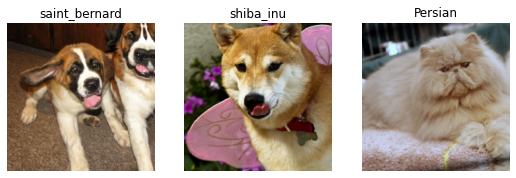

In [9]:
dls.show_batch(nrows=1, ncols=3)

In [10]:
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.561221,0.412721,0.128552,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.554117,0.357065,0.120433,01:04
1,0.435011,0.327076,0.102165,01:04
2,0.290525,0.260184,0.082544,01:05
3,0.207130,0.251155,0.077808,01:05


In [58]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics = error_rate).to_fp16()
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.938673,0.318802,0.099459,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.382265,0.340544,0.107578,01:09
1,0.364782,0.275875,0.087280,01:09
2,0.208137,0.181669,0.052774,01:09
3,0.119154,0.172751,0.049391,01:09


In [11]:
x,y = dls.one_batch()

In [12]:
y

TensorCategory([17, 24, 14, 36,  1,  2,  3,  6,  8,  4, 13, 35, 20,  3,  1,  9,  1, 22, 23, 15,  1,  6,  3, 23, 16, 18, 22,  2, 26,  0, 33, 21, 21, 33,  6, 27, 28,  6,  4, 16,  9,  4, 24, 23, 35, 11, 16,  0,
        31, 26, 11, 13, 14, 36,  1, 24,  1, 12, 21, 15, 14, 24,  4,  8], device='cuda:0')

In [13]:
preds, som = learn.get_preds(dl = [(x,y)])
preds[0]

tensor([2.7226e-07, 9.6034e-08, 2.2530e-08, 2.8939e-07, 9.2537e-09, 4.9177e-07, 5.9553e-10, 2.8122e-10, 5.5925e-08, 3.8202e-06, 4.3179e-05, 5.0999e-04, 5.1231e-07, 5.7230e-05, 6.3387e-09, 1.7276e-07,
        2.4667e-07, 9.9936e-01, 4.1033e-08, 5.4216e-08, 2.4766e-08, 2.4768e-09, 1.4915e-08, 1.0808e-08, 9.8405e-09, 2.3808e-10, 1.3653e-05, 9.6454e-10, 1.8358e-07, 4.1766e-09, 9.3042e-10, 7.6495e-09,
        3.2767e-07, 4.2651e-08, 1.0186e-05, 2.2259e-10, 1.8635e-07])

In [14]:
som[0]

TensorCategory(17)

A deeper dive into softmax, negative log likelihood and cross entropy loss

In [38]:
# Softmax
p = torch.tensor([[0,1,2], [3,5,2], [1,0,4]]).float()
p
# The first part we want to do is use the softmax, which essentially means transforming each output into probabilities that sum to 1
def my_softmax(x): return torch.exp(x)/ torch.exp(x).sum(dim = 1, keepdim = True)
def my_softmax2(x): return torch.exp(x) / torch.exp(x).sum(dim = 1).view(-1,1)
my_softmax(p), my_softmax2(p)
# The keepdim part here is crucial: if keepdim is false then the .sum returns the row sums but as a 1x3 dim tensor
# PyTorch then uses broadcasting and divides each element by the first, second and third sum respectively which is not what we want
# If the keepdim = True the return of the sum function is a 3x1 tensor and then correctly each element of the first row is divided by the sum of the first row

(tensor([[0.0900, 0.2447, 0.6652],
         [0.1142, 0.8438, 0.0420],
         [0.0466, 0.0171, 0.9362]]), tensor([[0.0900, 0.2447, 0.6652],
         [0.1142, 0.8438, 0.0420],
         [0.0466, 0.0171, 0.9362]]))

In [45]:
# Negative log likelihood
# After we have got probabilities we want to calculate the loss. We calculate those losses based on the correct label and the probability that was assigned to that label
target = torch.tensor([1, 0, 2])
preds = my_softmax(p)
print(preds)
target_probs = preds[range(len(preds)), target] #This part of the code selects the probability corresponding to the correct label
print(target_probs)
-torch.log(target_probs) # The smaller our probability the biggest the loss (if we predict 1 the loss will be 0)

tensor([[0.0900, 0.2447, 0.6652],
        [0.1142, 0.8438, 0.0420],
        [0.0466, 0.0171, 0.9362]])
tensor([0.2447, 0.1142, 0.9362])


tensor([1.4076, 2.1698, 0.0659])

In [49]:
F.log_softmax(p, dim = 1) # This Torch function calculates both in one step
F.nll_loss(F.log_softmax(p, dim = 1), target, reduction='none') #!!!!! F.nll_loss does not take the log! it only takes the minus part of the negative log likelihood

tensor([1.4076, 2.1698, 0.0659])

In [51]:
# Cross entropy loss
# This is parts 1&2 together
-torch.log(target_probs).mean()

tensor(1.2144)

In [53]:
#In PyTorch
loss_func = nn.CrossEntropyLoss()
print(loss_func(p, target))
# Or using the functional version
F.cross_entropy(p, target)

tensor(1.2144)


tensor(1.2144)

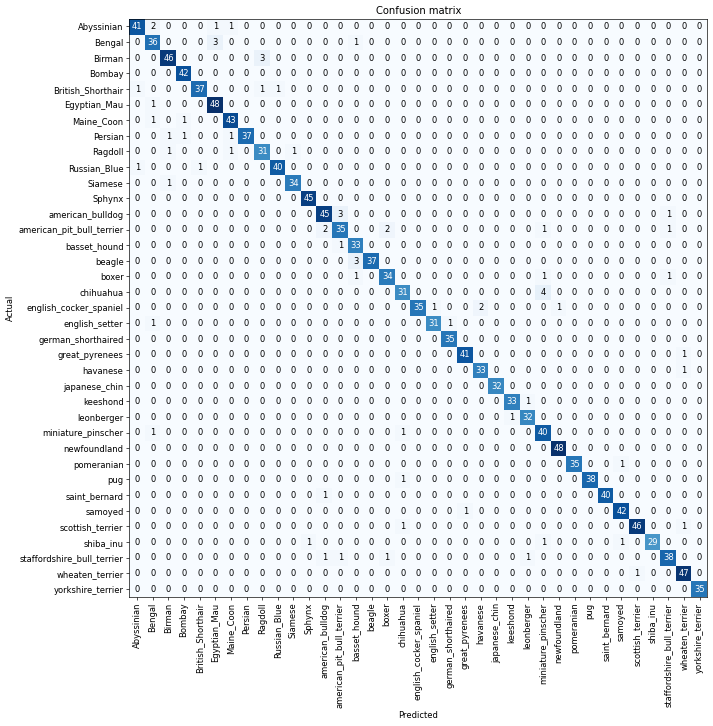

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [61]:
interp.most_confused(min_val = 4)

[('chihuahua', 'miniature_pinscher', 4)]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


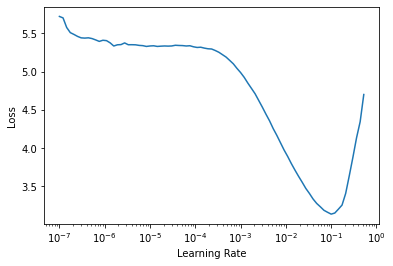

In [62]:
# Learning rate finder
learn = cnn_learner(dls, resnet34, metrics = error_rate)
lr_min, lr_steep = learn.lr_find()

In [64]:
lr_steep, lr_min
# We can try the steepest learning rate and compare it with just the default one (1e-3)

(0.004365158267319202, 0.010000000149011612)

In [65]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.489750,0.308893,0.112314,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.490785,0.276388,0.092693,01:15
1,0.315661,0.211539,0.073748,01:13


In [66]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(2, base_lr = lr_steep)

epoch,train_loss,valid_loss,error_rate,time
0,1.113457,0.340152,0.106225,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.607799,0.466531,0.131935,01:12
1,0.373141,0.271194,0.089310,01:13
